# Algorithm comparison

Identify the best machine learning algorithm for predicting what category a chemical from the test set belongs to

### Get the data  from [property_calculations](property_calculations.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import pickle

# Load property_array from property_calculations FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project')

dataset_path = path.join(BASE_DATA_PATH,
                         'fp',
                         'property_calculations',
                         'dataset.pkl')

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
train_features = dataset['train features']
train_labels = dataset['train labels']

### Test on different classifiers

In [3]:
#Scoring function
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score,\
                            precision_score, recall_score
import scipy.stats as st
import warnings

def t_delta(percent, scores):
    """
    Returns the size of a t-test error bar that defines a given percent confidence interval 
    """
    mean, sem = np.mean(scores), st.sem(scores)
    interval = st.t.interval(percent/float(100), len(scores)-1, loc=mean, scale=sem)
    delta = mean - interval[0]
    return delta


def scores(clf,
           features, labels,
           score_types, 
           title='estimator', printout=True):
    """
    Generates a dictionary with cross_validation scores  and summary statistics
    for a given clf (estimator), features, and labels
    """
    
    if printout:
        print('\n{}:' .format(title))
    
    summary_dict = {title: {}}

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=41)

    for scoring in score_types:
        scores = cross_val_score(clf, features, labels, cv=cv, scoring=scoring)
        mean =  np.mean(scores)
        # t-test 95% confidence interval
        delta = t_delta(95, scores)

        summary_dict[title][scoring] = (mean, delta)

        if printout:
            print('-', scoring, scores)
            print('Mean: {:.2f} (+/-{:.2f})' .format(mean, delta))

    return summary_dict

def multi_tester(step_list, clf_list, score_types):
    """
    Runs scores function on all clfs in clf_list.
    Preappends the steps in step_list to make a pipeline with clf at the end.
    Returns a scores list for each clf and a pipe_dict of all the pipes generated
    """
    pipe_dict = {}
    scores_list = []
    for clf in clf_list:
        new_steps = step_list[:]
        new_steps.append(('estimator', clf))
        new_pipe = Pipeline(new_steps)
        title = str(type(clf))    
        title = title.split('.')[-1][:-2]
        pipe_dict[title] = new_pipe
        scores_list.append(scores(new_pipe, train_features,
                                  train_labels, score_types,
                                  title=title, printout=True))
    return scores_list, pipe_dict

Test on Naive Bayes, Support Vector Machines, AdaBoost, Logistic Regression, and Neural Network classifiers

In [5]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

step_list = [('imputer', Imputer(strategy='mean')),
         ('scaler', MinMaxScaler())]

clf_list = [BernoulliNB(),
            SVC(),
            AdaBoostClassifier(),
            LogisticRegression(),
            MLPClassifier()]

score_types = ['accuracy', 
               'precision',
               'recall']

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores_list, pipe_dict = multi_tester(step_list, clf_list, score_types)


BernoulliNB:
- accuracy [ 0.76331361  0.82411067  0.77075099]
Mean: 0.79 (+/-0.08)
- precision [ 0.30821918  0.39316239  0.32432432]
Mean: 0.34 (+/-0.11)
- recall [ 0.703125  0.71875   0.75    ]
Mean: 0.72 (+/-0.06)

SVC:
- accuracy [ 0.87376726  0.87351779  0.87351779]
Mean: 0.87 (+/-0.00)
- precision [ 0.  0.  0.]
Mean: 0.00 (+/-nan)
- recall [ 0.  0.  0.]
Mean: 0.00 (+/-nan)

AdaBoostClassifier:
- accuracy [ 0.85996055  0.87747036  0.88537549]
Mean: 0.87 (+/-0.03)
- precision [ 0.43396226  0.525       0.575     ]
Mean: 0.51 (+/-0.18)
- recall [ 0.359375  0.328125  0.359375]
Mean: 0.35 (+/-0.04)

LogisticRegression:
- accuracy [ 0.8678501   0.88932806  0.86758893]
Mean: 0.87 (+/-0.03)
- precision [ 0.47169811  0.59090909  0.46938776]
Mean: 0.51 (+/-0.17)
- recall [ 0.390625  0.40625   0.359375]
Mean: 0.39 (+/-0.06)

MLPClassifier:
- accuracy [ 0.87771203  0.8972332   0.87747036]
Mean: 0.88 (+/-0.03)
- precision [ 0.52272727  0.61702128  0.53846154]
Mean: 0.56 (+/-0.13)
- recall [ 0.

### Visualize the different algorithm scores testing

In [6]:
def initialize_plot_dicto(dicto):
    """
    Initialize a flat plot_dicto with keys from dicto and epmty lists
    """
    og_key = list(dicto.keys())[0]
    keys = ['clf'] + list(dicto[og_key].keys())
    plot_dicto = {key: [] for key in keys}
    return plot_dicto

def build_plot_dicto(plot_dicto, scores_list):
    """
    Add values to plot_dicto from scores list
    """
    
    for dicto in scores_list:
        og_key = list(dicto.keys())[0]
        plot_dicto['clf'].append(og_key)
        keys = list(plot_dicto.keys())
        keys.remove('clf')
        for key in keys:
            plot_dicto[key].append(dicto[og_key][key])
    
    return plot_dicto

In [7]:
init_plot_dicto = initialize_plot_dicto(scores_list[0])
plot_dicto = build_plot_dicto(init_plot_dicto, scores_list)
print('plot_dicto = {}' .format(plot_dicto))

plot_dicto = {'precision': [(0.34190196518963645, 0.11207749778314796), (0.0, nan), (0.51132075471698113, 0.17763325269582014), (0.51066498640622637, 0.17265510666818407), (0.55940336259485191, 0.12548608287506935)], 'accuracy': [(0.78605842318216901, 0.082382369345724071), (0.87360094383505749, 0.00035779687109638303), (0.87426880069020541, 0.032309769120729359), (0.87492236488892006, 0.030993056294597143), (0.88413852962347939, 0.028172512265966065)], 'clf': ['BernoulliNB', 'SVC', 'AdaBoostClassifier', 'LogisticRegression', 'MLPClassifier'], 'recall': [(0.72395833333333337, 0.059290359902179124), (0.0, nan), (0.34895833333333331, 0.04481929926990913), (0.38541666666666669, 0.059290359902179124), (0.390625, 0.067228948904863639)]}


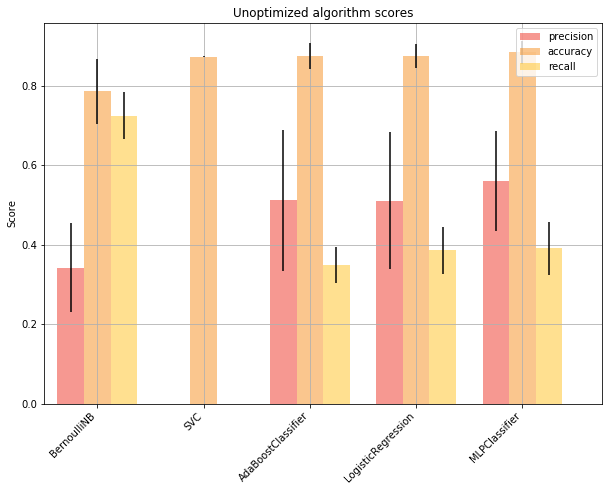

In [8]:
clfs = plot_dicto['clf']
score_list = list(plot_dicto.keys())
score_list.remove('clf')
colors = ['#EE3224', '#F78F1E', '#FFC222']

pos = list(range(len(clfs)))
width = 0.25

plt.close('all')
fig, ax = plt.subplots(figsize=(10,7))
for i, score in enumerate(score_list):
    value = plot_dicto[score]
    means, stds = zip(*value)
    plt.bar([p + width*i for p in pos],
            means,
            width,
            yerr=stds,
            alpha=0.5,
            color=colors[i],
            label=score)

ax.set_ylabel('Score')
ax.set_title('Unoptimized algorithm scores')
ax.set_xticks([p + width for p in pos])
ax.set_xticklabels(clfs, rotation=45, horizontalalignment='right')
plt.xlim(min(pos)-width, max(pos)+width*4)

plt.legend(loc='upper right')
plt.grid()
plt.show()

All unoptimized classifiers except SVC seem comparable. I will proceed tuning hyperparameters for Adaboost, Logistic Regression and MPL. I won't proceed with (because BernoulliNB because it doesn't have hyperparameters to optimize).

To find the best one I will exhaustively search all the possible combinations of several hyper-parameters and evaluate them with cross-validation in [parameter_optimization](parameter_optimization.ipynb).